In [1]:
#--------------------------------
# Imports
#--------------------------------
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import metpy
import metpy.calc as mpcalc
from netCDF4 import Dataset
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from matplotlib import colors
from matplotlib import cm
import PseudoNetCDF as pnc


In [2]:
#=======================================
# Diagnostics Parameters
#=======================================
space = '    '
#=======================================
# Functions
#=======================================
def print_diag(key,var):
    print(key)
    print(space,'Shape:',np.shape(var))
    print(space,'Max:',np.max(var))
    print(space,'Min:',np.min(var))
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

# Read in dropsonde dictionary created by reading in all publicly available dropsonde data (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [3]:
# Grab CAMP2Ex sonde files
path = '/discover/nobackup/mwstanfo/camp2ex_data/dropsondes/20190925/'
sonde_dict = pickle.load(open(path+'sonde_dict.p','rb'))
for key,val in sonde_dict.items():
    print(key,val.keys())
sonde_keys = list(sonde_dict.keys())

20190925_034939 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_041553 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_042708 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_045515 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_050347 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_063151 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])
20190925_064729 dict_keys(['pres', 'Td', 'temp', 'rh', 'u', 'v', 'alt', 'lat', 'lon', 'time', 'time_ts'])


# Read in DHARMA sounding file, provided on the NCCS portal for the CNTL simulation (https://portal.nccs.nasa.gov/datashare/giss-camp2ex/)

In [4]:
# Read in DHARMA sounding file
#path = '/discover/nobackup/mwstanfo/dharma_camp2ex/dharma/run/cntl_sb_1sec/'
path = '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/'
ncfile = xarray.open_dataset(path+'dharma.soundings.cdf',decode_times=False)

In [5]:
def return_skewt_params(p,T,rh,qv,u,v,time_id,z):
    p = p[time_id,:]
    T = T[time_id,:]
    qv = qv[time_id,:]
    rh = rh[time_id,:]
    u = u[time_id,:]
    v = v[time_id,:]
    
    z = z * units('m')
    u = u * units('m/s')
    v = v * units('m/s')
    rh = rh * units('%')
    q = qv * units('g/kg')
    p = p * units.hPa
    T = T * units.K
    Td = mpcalc.dewpoint_from_relative_humidity(T,rh)

    u = u.to('kts')
    v = v.to('kts')
    
    wind_dir = metpy.calc.wind_direction(u, v, convention='from')
    wind_speed = metpy.calc.wind_speed(u, v)
    
    out_dict = {'p':p,\
                'T':T,\
                'Td':Td,\
                'u':u,\
                'v':v,\
                'wind_dir':wind_dir,\
                'wind_speed':wind_speed,\
                'z':z,\
               }
    
    return out_dict

# Process DHARMA sounding data

In [6]:
zt = ncfile['zt'].values # m
u = ncfile['u'].values-2.5 # m/s
v = ncfile['v'].values-4 # m/s
temp = ncfile['T'].values # K
rh = ncfile['RH'].values # %
qv = ncfile['qv'].values # g/kg
theta_00 = ncfile.attrs['theta_00'] # K
tmp_theta = ncfile['th'].values # K

time_id = 0

# Compute Exner function
theta = (tmp_theta+1)*theta_00
pi = temp/theta

# Compute environment pressure in Pa
Pref = 1.e5
p = Pref*pi**(1./0.286)
p = p*1.e-2 # hPa

tmp_dict = return_skewt_params(p,temp,rh,qv,u,v,time_id,zt)

target_heights = [1,2,3,4,5,6,7,8,9,10]#,11,12,13,14,15]
height_ids = []
heights_nearest = []
for ii in range(len(target_heights)):
    nearest_val,nearest_id = find_nearest(zt*1.e-3,target_heights[ii])
    height_ids.append(nearest_id)
    heights_nearest.append(nearest_val)

# Read in large-scale vertical motion file, also provided on NCCS portal

In [9]:
path = '/discover/nobackup/mwstanfo/dharma_camp2ex/dharma/run/'
file = path+'camp2ex.input_forcing.cntl'
file = open(file,'r')
content = file.readlines()
content = content[1:-7]
num_lines = len(content)

heights = []
w = []
for ii in range(num_lines):
    dum_line = content[ii].split('    ')
    heights.append(float(dum_line[1]))
    tmp_w = dum_line[-1]
    w.append(float(tmp_w))
heights = np.array(heights)
w = np.array(w)

# Plot sounding and large-scale vertical motion (Fig. 3)

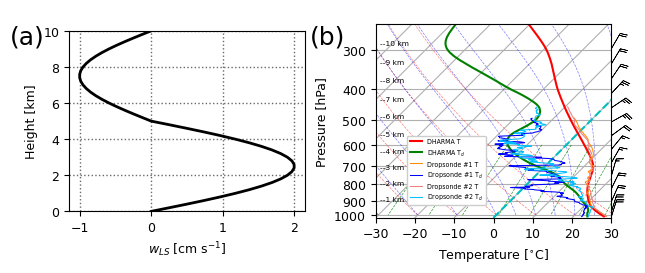

In [10]:
fig = plt.figure(figsize=(7,4))
gs = matplotlib.gridspec.GridSpec(nrows=5,ncols=2,figure=fig,wspace=0.3)#,wspace=0.4,hspace=0.6)
skew = SkewT(fig, rotation=45,subplot=gs[:,1])
ax2 = fig.add_subplot(gs[1:4,0])

Fontsize=9

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30, 30)    
skew.ax.tick_params(labelsize=Fontsize)
skew.ax.set_xlabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
skew.ax.set_ylabel('Pressure [hPa]',fontsize=Fontsize)
# Add the relevant special lines
skew.plot_dry_adiabats(lw=0.5)
skew.plot_moist_adiabats(lw=0.5)
skew.plot_mixing_lines(lw=0.5)  
skew.ax.axvline(0, color='c', linestyle='--', linewidth=1.5)
#skew.plot_barbs(p[::3], u[::3], v[::3],x_clip_radius=0.3)  

# DHARMA
skew.plot(tmp_dict['p'], tmp_dict['T'], 'r',lw=1.5)
skew.plot(tmp_dict['p'], tmp_dict['Td'], 'g',lw=1.5)
dum = -60
inc = 8
skew.plot_barbs(tmp_dict['p'][:dum:inc], tmp_dict['u'][:dum:inc], tmp_dict['v'][:dum:inc],lw=0.5,length=5)


for p_tick, t_tick, h_tick in zip(tmp_dict['p'][height_ids],tmp_dict['T'][height_ids],tmp_dict['z'][height_ids]):
    if p_tick >= 125 * units.hPa:
        trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
        dum = int(round(h_tick.m*1.e-3,0))
        skew.ax.text(0.02,p_tick,'--{}{}'.format(dum,' km'),transform=trans,fontsize=Fontsize*0.6)

#if True:
color1 = ['darkorange','lightcoral']
color2 = ['blue','deepskyblue']
for ii in range(2):
    key = sonde_keys[ii]
    sonde_keys = list(sonde_dict.keys())
    tmp_pres = sonde_dict[key]['pres']
    tmp_temp = sonde_dict[key]['temp']
    #tmp_Td = sonde_dict[key]['Td']
    tmp_u = sonde_dict[key]['u']
    tmp_v = sonde_dict[key]['v']
    tmp_rh = sonde_dict[key]['rh']
    tmp_alt = sonde_dict[key]['alt']
    dumid = np.where(~np.isnan(tmp_alt))
    tmp_pres = tmp_pres[dumid]
    tmp_temp = tmp_temp[dumid]
    tmp_u = tmp_u[dumid]
    tmp_v = tmp_v[dumid]
    tmp_rh = tmp_rh[dumid]
    tmp_alt = tmp_alt[dumid]

    u = tmp_u * units('m/s')
    v = tmp_v * units('m/s')
    tmp_rh = tmp_rh * units('%')
    p = tmp_pres * units('hPa')
    T = tmp_temp * units('degC')
    Td = mpcalc.dewpoint_from_relative_humidity(T,tmp_rh)

    #skew.plot(p, T, 'blue',lw=2)
    skew.plot(p, T, color1[ii],lw=0.75)
    #skew.plot(p, Td, 'darkorange',lw=2)    
    skew.plot(p, Td, color2[ii],lw=0.75)    
    
    
skew.ax.set_ylim(1020,250)


labels=['DHARMA T','DHARMA T$_{d}$','Dropsonde #1 T','Dropsonde #1 T$_{d}$','Dropsonde #2 T','Dropsonde #2 T$_{d}$']

lgnd_elements = [Line2D([0],[0],color='r',label=labels[0],lw=1.5),\
                 Line2D([0],[0],color='g',label=labels[1],lw=1.5),\
                 Line2D([0],[0],color='darkorange',label=labels[2],lw=0.75),\
                 Line2D([0],[0],color='blue',label=labels[3],lw=0.75),\
                 Line2D([0],[0],color='lightcoral',label=labels[4],lw=0.75),\
                 Line2D([0],[0],color='deepskyblue',label=labels[5],lw=0.75),\
                ]

skew.ax.legend(handles=lgnd_elements,fontsize=Fontsize*0.5,loc='lower center',bbox_to_anchor=(0.3,0.05),framealpha=1,ncol=1)


#-------------------------------------------------------------
#-------------------------------------------------------------
# Linear profiles for easier interpretation of inversions
#-------------------------------------------------------------
#-------------------------------------------------------------
ax2.tick_params(labelsize=Fontsize)
ax2.grid(which='both',lw=1,c='dimgrey',ls='dotted')
ax2.set_ylabel('Height [km]',fontsize=Fontsize)
ax2.plot(w,heights*1.e-3,lw=2,c='k')
ax2.set_ylim(0,10)
ymax=10
dumid = np.where(heights <= 10000.)[0]
mean_wLS = np.mean(w[dumid])
#ax2.text(0.99,0.99,'Mean $w_{LS}$ = '+str(np.around(mean_wLS,2))+' cm s$^{-1}$',\
#         transform=ax2.transAxes,fontsize=Fontsize*0.9,fontweight='bold',va='top',ha='right')
ax2.set_xlabel('$w_{LS}$ [cm s$^{-1}$]',fontsize=Fontsize)


ax2.text(-0.25,0.93,'(a)',fontsize=Fontsize*2,transform=ax2.transAxes)
skew.ax.text(-0.28,0.9,'(b)',fontsize=Fontsize*2,transform=skew.ax.transAxes)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_03.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()